In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from tqdm import tqdm

# Patterned data generator
def generate_complex_patterned_data(num_samples, num_rois, time_steps):
    X = torch.zeros(num_samples, num_rois, time_steps)
    y = torch.zeros(num_samples, dtype=torch.long)

    for i in range(num_samples):
        for roi in range(num_rois):
            # Mix of sinusoidal, linear, and random noise patterns
            if i < num_samples // 2:
                # Class 0: Mix of patterns with more emphasis on sinusoidal
                signal = (
                    0.6 * torch.sin(torch.linspace(0, 2 * np.pi, time_steps)) +
                    0.3 * torch.linspace(0, 1, time_steps) +
                    0.1 * torch.randn(time_steps)
                )
            else:
                # Class 1: Mix of patterns with more emphasis on linear
                signal = (
                    0.3 * torch.sin(torch.linspace(0, 2 * np.pi, time_steps)) +
                    0.6 * torch.linspace(0, 1, time_steps) +
                    0.1 * torch.randn(time_steps)
                )
            X[i, roi, :] = signal

        y[i] = 0 if i < num_samples // 2 else 1

    return X, y

# Time-series Encoder
class TimeSeriesEncoder(nn.Module):
    def __init__(self, num_rois, time_steps, embedding_size):
        super(TimeSeriesEncoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=time_steps, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=embedding_size, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Permute to (batch_size, time_steps, num_rois)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # Permute back to (batch_size, num_rois, embedding_size)
        return x

# Graph Generator
class GraphGenerator(nn.Module):
    def __init__(self, embedding_size, num_rois):
        super(GraphGenerator, self).__init__()
        self.fc = nn.Linear(embedding_size, num_rois)

    def forward(self, x):
        hA = F.softmax(self.fc(x), dim=-1)
        A = torch.bmm(hA, hA.transpose(1, 2))
        return A

# Graph Predictor using GCN
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

# End-to-end model
class FBNetGen(nn.Module):
    def __init__(self, num_rois, time_steps, embedding_size, hidden_channels, num_classes):
        super(FBNetGen, self).__init__()
        self.encoder = TimeSeriesEncoder(num_rois, time_steps, embedding_size)
        self.graph_generator = GraphGenerator(embedding_size, num_rois)
        self.gcn = GCN(embedding_size, hidden_channels, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        A = self.graph_generator(x)
        node_features = x.reshape(-1, x.size(2))  # Flatten to (num_samples * num_rois, embedding_size)
        num_nodes = node_features.size(0)
        edge_index = torch.randint(0, num_nodes, (2, 500)).to(x.device)  # Ensure edge_index matches the number of nodes

        # Adjust the batch tensor to match the flattened node_features
        batch = torch.repeat_interleave(torch.arange(x.size(0)), x.size(1)).to(x.device)

        output = self.gcn(node_features, edge_index, batch)
        return output

# Hyperparameters
num_samples = 1000
num_rois = 264
time_steps = 120
embedding_size = 16
hidden_channels = 32
num_classes = 2
batch_size = 32
epochs = 10
learning_rate = 0.001

# Generate patterned data
X, y = generate_complex_patterned_data(num_samples, num_rois, time_steps)

# Train-test split
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FBNetGen(num_rois, time_steps, embedding_size, hidden_channels, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with tqdm
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, unit="batch") as tepoch:
        for X_batch, y_batch in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{epochs}")
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

# Evaluation with tqdm
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    with tqdm(test_loader, unit="batch") as ttest:
        for X_batch, y_batch in ttest:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_labels.append(y_batch)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Metrics Calculation
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auroc = roc_auc_score(all_labels, all_preds)
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUROC: {auroc:.4f}')
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')


Epoch 1/10: 100%|██████████| 25/25 [00:01<00:00, 20.14batch/s, loss=0.0249]


Epoch 1/10, Loss: 0.3875


Epoch 2/10: 100%|██████████| 25/25 [00:00<00:00, 57.74batch/s, loss=5.77e-5] 


Epoch 2/10, Loss: 0.0025


Epoch 3/10: 100%|██████████| 25/25 [00:00<00:00, 57.19batch/s, loss=1.62e-5]


Epoch 3/10, Loss: 0.0000


Epoch 4/10: 100%|██████████| 25/25 [00:00<00:00, 56.99batch/s, loss=2.01e-5]


Epoch 4/10, Loss: 0.0000


Epoch 5/10: 100%|██████████| 25/25 [00:00<00:00, 57.69batch/s, loss=2.45e-5]


Epoch 5/10, Loss: 0.0000


Epoch 6/10: 100%|██████████| 25/25 [00:00<00:00, 58.20batch/s, loss=1.12e-5]


Epoch 6/10, Loss: 0.0000


Epoch 7/10: 100%|██████████| 25/25 [00:00<00:00, 55.85batch/s, loss=1.22e-5]


Epoch 7/10, Loss: 0.0000


Epoch 8/10: 100%|██████████| 25/25 [00:00<00:00, 57.96batch/s, loss=9.33e-6]


Epoch 8/10, Loss: 0.0000


Epoch 9/10: 100%|██████████| 25/25 [00:00<00:00, 57.37batch/s, loss=7.35e-6]


Epoch 9/10, Loss: 0.0000


Epoch 10/10: 100%|██████████| 25/25 [00:00<00:00, 57.82batch/s, loss=1.04e-5]


Epoch 10/10, Loss: 0.0000


100%|██████████| 7/7 [00:00<00:00, 59.00batch/s]

Accuracy: 1.0000
F1 Score: 1.0000
AUROC: 1.0000
Sensitivity: 1.0000
Specificity: 1.0000


In [4]:
# print train_loader
for X_batch, y_batch in train_loader:
    print(X_batch.shape)
    print(y_batch.shape)
    print(X_batch[0])
    break

torch.Size([32, 264, 120])
torch.Size([32])
tensor([[ 0.0663,  0.0749,  0.0649,  ...,  0.2813,  0.2304,  0.2254],
        [ 0.0219,  0.0730,  0.0239,  ...,  0.2697,  0.3363,  0.1743],
        [ 0.0894,  0.0586, -0.0495,  ...,  0.1328,  0.1991,  0.1224],
        ...,
        [ 0.1220, -0.2097,  0.0352,  ...,  0.2199,  0.3605,  0.3686],
        [ 0.0884, -0.0085,  0.0861,  ...,  0.1296,  0.4395,  0.3155],
        [-0.0245,  0.1269,  0.1323,  ...,  0.1967,  0.2036,  0.1931]])


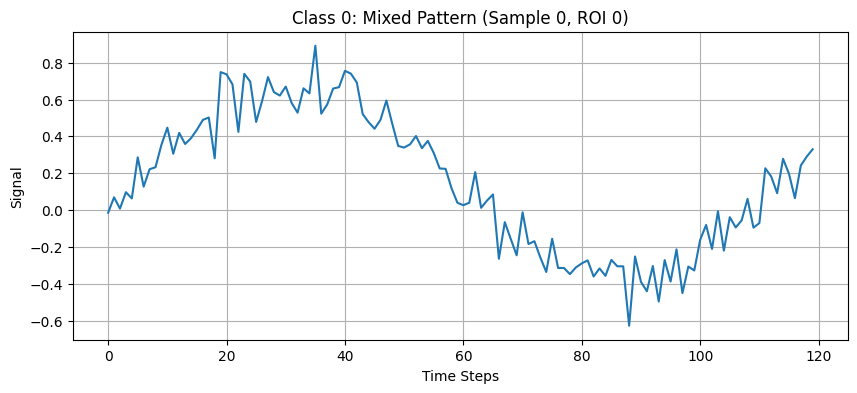

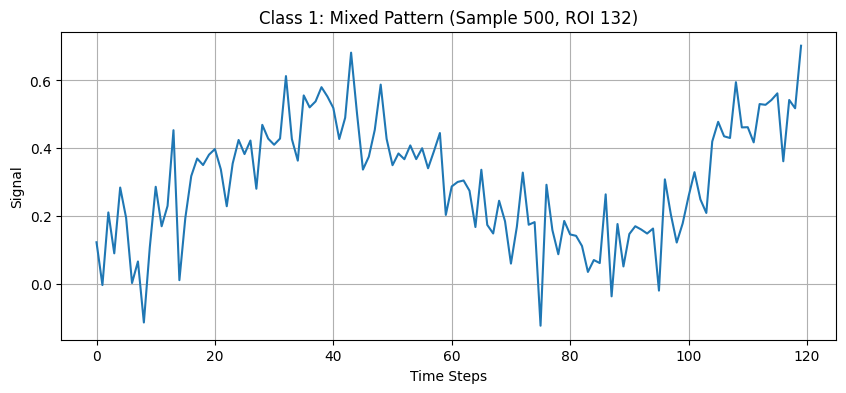

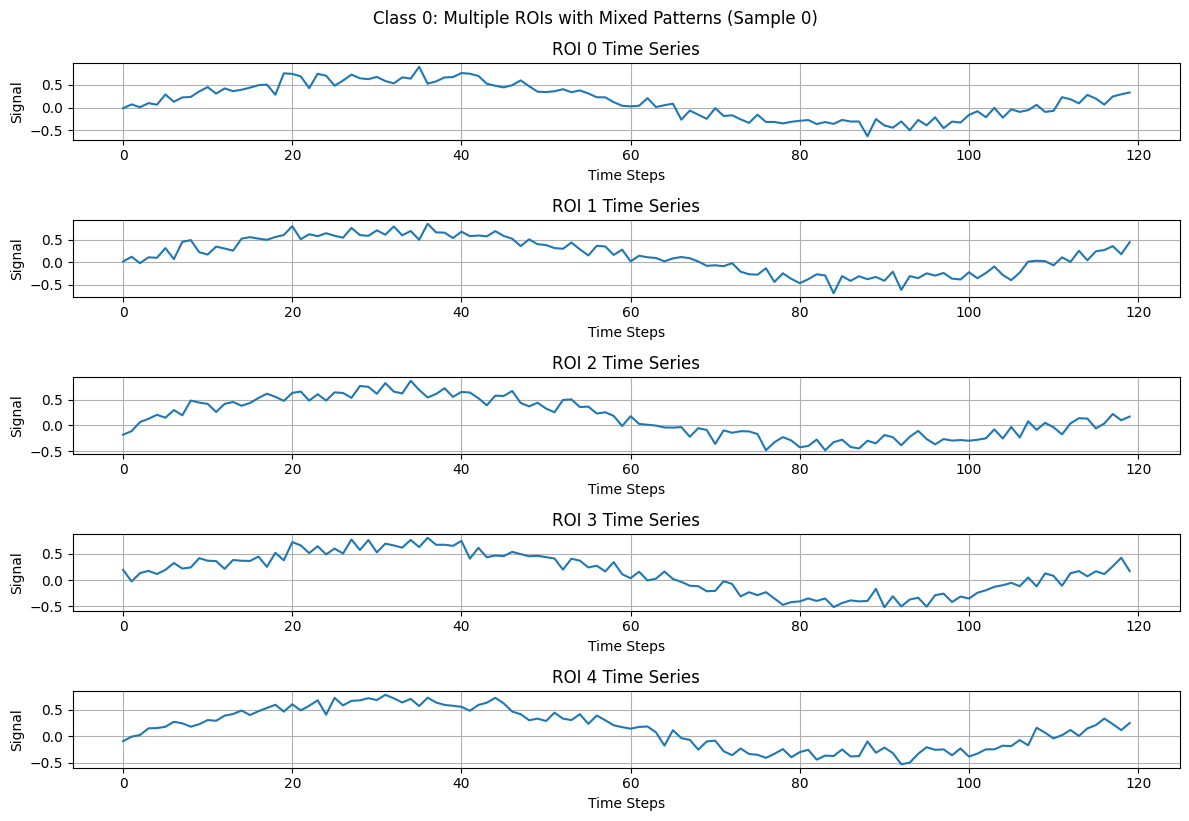

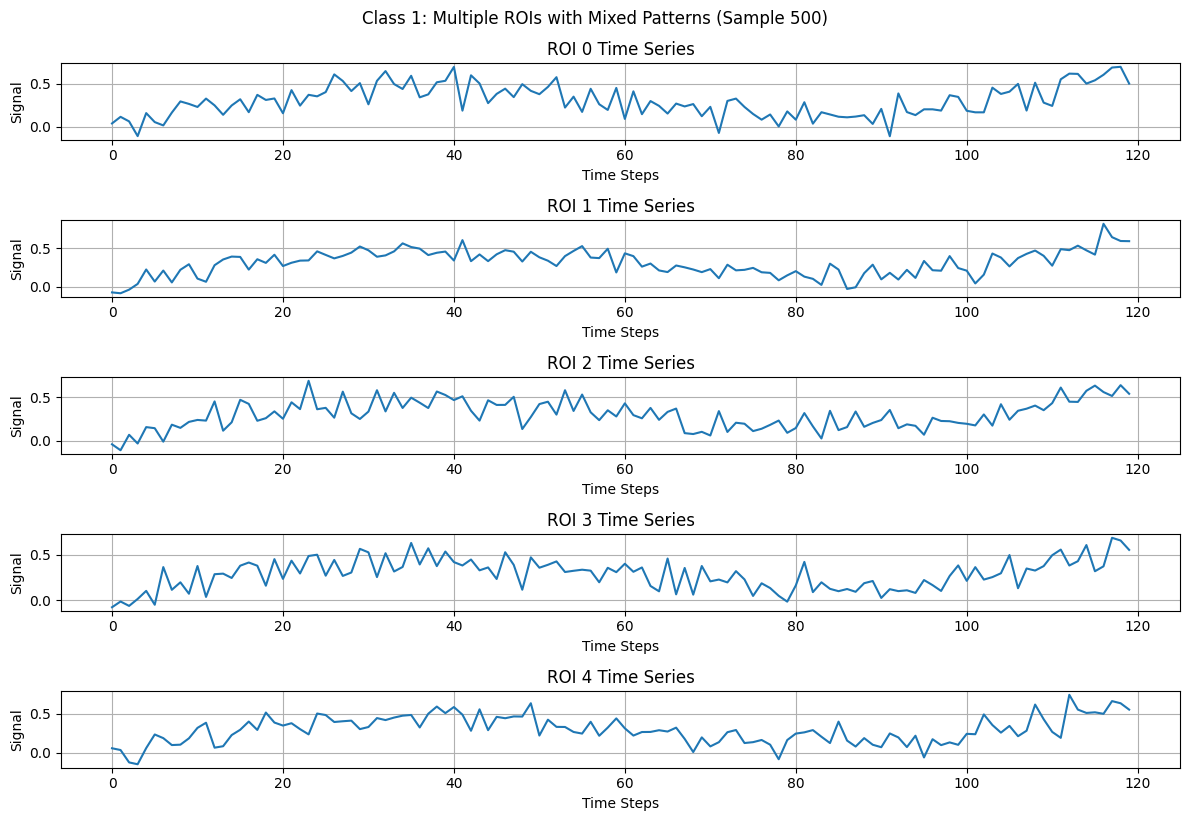

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Complex and ambiguous patterned data generator
def generate_complex_patterned_data(num_samples, num_rois, time_steps):
    X = torch.zeros(num_samples, num_rois, time_steps)
    y = torch.zeros(num_samples, dtype=torch.long)

    for i in range(num_samples):
        for roi in range(num_rois):
            # Mix of sinusoidal, linear, and random noise patterns
            if i < num_samples // 2:
                # Class 0: Mix of patterns with more emphasis on sinusoidal
                signal = (
                    0.6 * torch.sin(torch.linspace(0, 2 * np.pi, time_steps)) +
                    0.3 * torch.linspace(0, 1, time_steps) +
                    0.1 * torch.randn(time_steps)
                )
            else:
                # Class 1: Mix of patterns with more emphasis on linear
                signal = (
                    0.3 * torch.sin(torch.linspace(0, 2 * np.pi, time_steps)) +
                    0.6 * torch.linspace(0, 1, time_steps) +
                    0.1 * torch.randn(time_steps)
                )
            X[i, roi, :] = signal

        y[i] = 0 if i < num_samples // 2 else 1

    return X, y

# Visualize a single sample's ROI across time steps
def plot_single_roi(X, sample_idx, roi_idx, title="ROI Time Series"):
    plt.figure(figsize=(10, 4))
    plt.plot(X[sample_idx, roi_idx, :].numpy())
    plt.title(f"{title} (Sample {sample_idx}, ROI {roi_idx})")
    plt.xlabel("Time Steps")
    plt.ylabel("Signal")
    plt.grid(True)
    plt.show()

# Visualize multiple ROIs for a single sample
def plot_multiple_rois(X, sample_idx, num_rois=5, title="Multiple ROIs Time Series"):
    plt.figure(figsize=(12, 8))
    for i in range(num_rois):
        plt.subplot(num_rois, 1, i + 1)
        plt.plot(X[sample_idx, i, :].numpy())
        plt.title(f"ROI {i} Time Series")
        plt.xlabel("Time Steps")
        plt.ylabel("Signal")
        plt.grid(True)
    plt.tight_layout()
    plt.suptitle(f"{title} (Sample {sample_idx})", y=1.02)
    plt.show()

# Generate complex patterned data
num_samples = 1000
num_rois = 264
time_steps = 120
X, y = generate_complex_patterned_data(num_samples, num_rois, time_steps)

# Example visualizations
# Visualize a pattern from class 0 (sample 0)
plot_single_roi(X, sample_idx=0, roi_idx=0, title="Class 0: Mixed Pattern")

# Visualize a pattern from class 1 (sample 500)
plot_single_roi(X, sample_idx=500, roi_idx=132, title="Class 1: Mixed Pattern")

# Visualize multiple ROIs for a sample from class 0
plot_multiple_rois(X, sample_idx=0, num_rois=5, title="Class 0: Multiple ROIs with Mixed Patterns")

# Visualize multiple ROIs for a sample from class 1
plot_multiple_rois(X, sample_idx=500, num_rois=5, title="Class 1: Multiple ROIs with Mixed Patterns")
